## Metodologia de Desenvolvimento

### Step by Step 

#####  1. Transformação das variaveis categóricas com 3 ou mais categorias usando o Weight of Evidence (WOE)

        OBS: O Desenvolvimento dessa transformação foi no SQL.

##### 2. As variaveis binárias com apenas 2 categorias, foi criado colunas binarizadas para elas.

        OBS: O Desenvolvimento dessa transformação foi no SQL.

##### 3. As variaveis com Information Values < 0.10 foi descartada, pois não possui efeito significativo para a variavel resposta, segundo a metodologia do WOE.

##### 4. Descartar as variaveis com baixa variância 

##### 5. Descarta as Variaveis com Alto Correlação


##### 7. 70% da base foi usado para treinamento do modelo

        7.1 Algoritmo: Xgboost
        7.2 Parametros do Xgboost por Grid Search.
        7.3 Metodologia de Treino Kfolds com k igual a 5

##### 6. Balaceamento Amostral (1:1) 

        OBS: O Balanceamento é aplicado apenas na base de treino.

##### 8. 30% da base foi separado para realizar a validação do modelo com as métricas: 

        8.1 ROC
        8.2 KS
        8.3 Recall
        8.4 Gráfico da distribuição da probabilidade (Score)
        8.5 Matriz de Confusão
    
  
### variaveis


     age:         Int 	
     job:         Category   	
     marital:     Category 	
     education:   Category 
     default:     Category 
     balance:     numeric
     housing:     Yes or No
     loan:        Yes or No
     contact:     Category 
     day:         Int
     month:       Category 
     duration:    numeric
     campaign:    int
     pdays:       int
     previous:    int
     poutcome:    Category 
     y:           Target

In [1]:
import pandas as pd
from  datetime import datetime
import itertools
import pickle
import numpy as np
import xgboost as xgb
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import *
from sklearn.model_selection import GridSearchCV
import time
from scipy.stats import ks_2samp
import sklearn.metrics as mt
from matplotlib import pyplot as plt
from xgboost import plot_importance
import seaborn as sns
import pyodbc
from sklearn import preprocessing as preprocessing 
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, \
                            roc_curve, precision_recall_curve, auc, average_precision_score

In [2]:
# load data
                            
driver   = '{SQL Server}'
server   = 'localhost\SQLEXPRESS'
database = 'Pos_Grauacao'
connection = pyodbc.connect('DRIVER='+driver+';SERVER='+server+';Database='+database+';Trusted_Connection=yes;')
cursor = connection.cursor()
select_string= """ SELECT * FROM BASE_MODELO_FINAL_HISTORICO""" 
df = pd.read_sql(select_string,connection)

In [3]:
df_QA = df
features = list(df_QA.columns[2:])

df_QA.head(10)

,costumer_ID,y,age,job_WOE,default_Yes,default_No,balance,housing_Yes,housing_No,loan_Yes,loan_No,day,contact_WOE,month_WOE,duration,campaign,pdays,previous,poutcome_WOE
0,1,0,58,-0.185555,0,1,2143.0,1,0,0,1,5.0,1.138508,0.609306,261.0,1,-1,0,0.272775
1,2,0,44,0.063634,0,1,29.0,1,0,0,1,5.0,1.138508,0.609306,151.0,1,-1,0,0.272775
2,3,0,33,0.384694,0,1,2.0,1,0,1,0,5.0,1.138508,0.609306,76.0,1,-1,0,0.272775
3,4,0,47,0.523900,0,1,1506.0,1,0,0,1,5.0,1.138508,0.609306,92.0,1,-1,0,0.272775
4,5,0,33,-0.010325,0,1,1.0,0,1,0,1,5.0,1.138508,0.609306,198.0,1,-1,0,0.272775
5,6,0,35,-0.185555,0,1,231.0,1,0,0,1,5.0,1.138508,0.609306,139.0,1,-1,0,0.272775
6,7,0,28,-0.185555,0,1,447.0,1,0,1,0,5.0,1.138508,0.609306,217.0,1,-1,0,0.272775
7,8,0,42,0.384694,1,0,2.0,1,0,0,1,5.0,1.138508,0.609306,380.0,1,-1,0,0.272775
8,9,0,58,-0.801178,0,1,121.0,1,0,0,1,5.0,1.138508,0.609306,50.0,1,-1,0,0.272775
9,10,0,43,0.063634,0,1,593.0,1,0,0,1,5.0,1.138508,0.609306,55.0,1,-1,0,0.272775


In [4]:
## Removendo as Variaveis com Baixa Variância

variable_names = []

Selector = VarianceThreshold(threshold = 0.07)
Selector.fit(df_QA[features])
 
for x in range(0, len(df_QA[features].columns)):
    if(Selector.get_support()[x] == False):
        variable_names.append(df_QA[features].columns[x])

In [5]:
### Removendo Variaveis por Autocorrelação 

features_col = list(df_QA.columns[2:])
    
variaveis = set()

correlation_matrix = df_QA[features_col].corr()

for i in range(correlation_matrix.shape[0]):
        for j in range(i+1):
            if( abs(correlation_matrix.iloc[i,j]) >= 0.9 and abs(correlation_matrix.iloc[i,j]) < 1 ):
                if(correlation_matrix.columns[j] not in variaveis):
                    variaveis.add(correlation_matrix.columns[j])
                    
variaveis

set()

In [6]:
df_QA = df_QA.drop(variaveis,axis = 1)
df_QA = df_QA.drop(variable_names,axis = 1)
features_final = list(df_QA.columns[2:])

In [7]:
X_train, X_test = train_test_split(df_QA, test_size=0.3, random_state=int(time.time()))

In [8]:
## Balanceamento Amostral

df_target = X_train[X_train.y == 1]
df_x = X_train[X_train.y == 0].sample(len(df_target))
X_train = pd.concat([df_target,df_x],axis = 0)
X_train = X_train.sample(len(X_train))

In [9]:
parameters = {'nthread':[10], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.05,0.6], #so called `eta` value
              'max_depth': [6,30],
              'min_child_weight': [11,30],
              'silent': [1],
              'subsample': [0.4,0.7],
              'colsample_bytree': [0.5,0.7],
              'n_estimators': [100], #number of trees, change it to 1000 for better results
              'missing':[-999],
              'seed': [1337]}


In [10]:
xgb_model = xgb.XGBClassifier()
clf = GridSearchCV(xgb_model, parameters, n_jobs=2, 
                   cv=5, 
                   scoring='roc_auc',
                   verbose=1, refit=True)
clf.fit(X_train[features_final], X_train["y"])     

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   22.2s
[Parallel(n_jobs=2)]: Done 160 out of 160 | elapsed:  1.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'nthread': [10], 'objective': ['binary:logistic'], 'learning_rate': [0.05, 0.6], 'max_depth': [6, 30], 'min_child_weight': [11, 30], 'silent': [1], 'subsample': [0.4, 0.7], 'colsample_bytree': [0.5, 0.7], 'n_estimators': [100], 'missing': [-999], 'seed': [1337]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [11]:
X_test['Score'] = clf.predict_proba(X_test[features_final])[:,1]
X_train['Score'] = clf.predict_proba(X_train[features_final])[:,1]

C:\Users\rsilva\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [12]:
df_label  = X_test.loc[X_test['y'] == 1]
df_X  = X_test.loc[X_test['y'] == 0]

In [13]:
np.random.seed(12345678)


In [14]:
AUC = mt.roc_auc_score(X_test['y'],  X_test["Score"])
print("Area roc na base de teste é igual a: ",round(AUC,2))

Area roc na base de teste é igual a:  0.93


In [15]:
ks = ks_2samp(df_label.Score,df_X.Score)
print("KS na base de teste é igual a:",round(ks[0],2))

KS na base de teste é igual a: 0.73


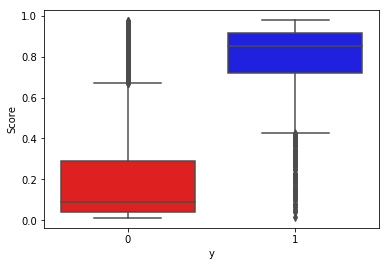

In [16]:
ax = sns.boxplot(x="y", y="Score", data=df_label, order = [0,1],color = "blue")
ax = sns.boxplot(x="y", y="Score", data=df_X,order = [0,1],color = "red")

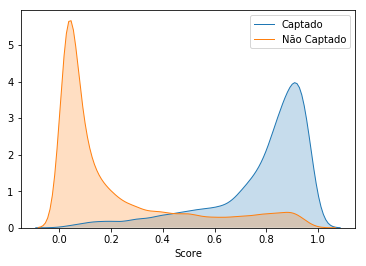

In [17]:
sns.distplot(dataset["Score"], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 1}, 
                  label = "Captado")

sns.distplot((df_X.Score), hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 1}, 
                  label = "Não Captado")

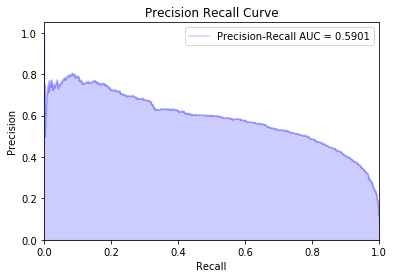

In [18]:
y_test = X_test['y']
y_proba_predicted = X_test['Score']


precision, recall, thresholds = precision_recall_curve(y_test, y_proba_predicted)
avg_precision = average_precision_score(y_test, y_proba_predicted)

step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
plt.step(recall, precision, color='b', alpha=0.2,
             where='post', label = 'Precision-Recall AUC = %0.4f' % avg_precision)
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
plt.legend(loc = 1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision Recall Curve')
plt.show()

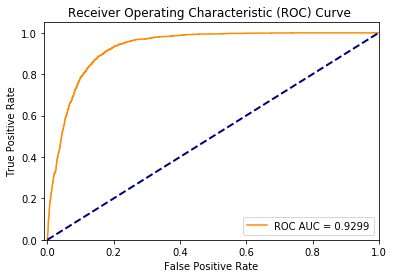

In [19]:
 # Plot AUC Curve

fpr, tpr, threshold = roc_curve(y_test, y_proba_predicted)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic (ROC) Curve ')
plt.plot(fpr, tpr, color='darkorange', label = 'ROC AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [20]:

def plot_confusion_matrix(y_test, y_proba_predicted, threshold):
    """
    Plot confusion matrix for a given values of y_test, y_proba_predicted, and threshold
    """
    cm = confusion_matrix(y_test, (y_proba_predicted > threshold).astype(int))
    classes = ['N', 'S']

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [21]:

# Find precision and threshold for 0.95 recall
print('\nFocus on high recall\n')
idx = np.argmax(recall<0.95)
threshold = thresholds[idx]
print('Threshold:', np.round(threshold, 3))
print('Precision:', np.round(precision[idx],4))
print('Recall:', np.round(recall[idx], 4))


Focus on high recall

Threshold: 0.328
Precision: 0.3461
Recall: 0.9495


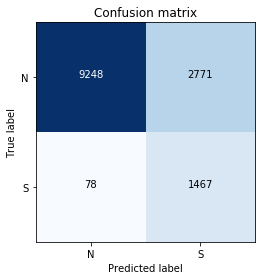

In [22]:
plot_confusion_matrix(y_test, y_proba_predicted,threshold)


Focus on high precision

Threshold: 0.688
Precision: 0.5002
Recall: 0.7858


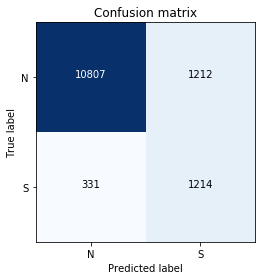

In [23]:
print('\nFocus on high precision\n')
idx = np.argmax(precision>0.5)
threshold = thresholds[idx]
print('Threshold:', np.round(threshold, 3))
print('Precision:', np.round(precision[idx],4))
print('Recall:', np.round(recall[idx], 4))
    
plot_confusion_matrix(y_test, y_proba_predicted, threshold)

In [24]:
## Features Importance

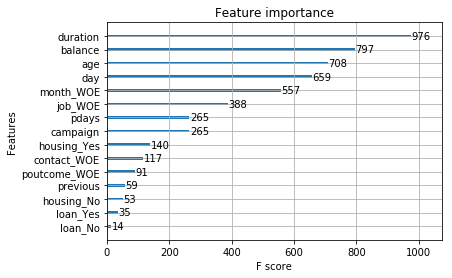

In [25]:
# plot feature importance
plot_importance(clf.best_estimator_)

In [26]:
print_f = ["costumer_ID","Score"]
pd.DataFrame(X_test[print_f]).head(10)

,costumer_ID,Score
21412,24533,0.029232
2354,2355,0.024628
42173,42174,0.453597
23695,14336,0.813753
1278,1279,0.020432
4987,29948,0.089383
13845,26735,0.371362
20932,24053,0.804476
4913,29874,0.049099
43160,43161,0.935919


In [27]:
connect = connection

cursor_log = connect.cursor()

#    cursor_log.fast_executemany = True
    
f = ["costumer_ID","Score","y"]

sql_query = """INSERT base_scorada
                    (costomer_ID,
                      Score,
                      y
                      ) 
                    values(?,?,?)"""
                    
 
cursor_log.executemany(sql_query,(pd.DataFrame(X_test[f])).values.tolist())
cursor_log.commit()
cursor_log.close()